El modelo implementado corresponde a un segmentador semántico, inspirado en la arquitectura Vision Transformer (ViT), pero construido completamente desde cero, sin utilizar modelos preentrenados, sin cargar pesos externos.
-
---

El sistema se compone de dos módulos principales:

- Encoder basado en un Transformer encoder que opera sobre patches de la imagen.

- Decoder convolucional progresivo que reconstruye un mapa de segmentación en resolución completa.
---

1. Patch Embedding (Tokenización de la Imagen)

La imagen de entrada (300×300) se divide en patches de 15×15 píxeles mediante una operación Conv2D con:

- kernel = 15

- stride = 15

Cada patch se proyecta a un vector de dimensión 768, generando 400 tokens en total.

Este módulo reemplaza la convolución tradicional y convierte la imagen en una secuencia, permitiendo procesarla con un Transformer.

2. Positional Embedding

Como los Transformers no tienen noción espacial, se introduce un vector de positional embedding entrenable para cada patch.

Estos embeddings preservan la estructura espacial de la imagen para facilitar la segmentación.

3. Vision Transformer Encoder

El encoder está compuesto por 6 bloques Transformer, cada uno incluye:

- LayerNorm

- Multi-Head Self-Attention (12 cabezas)

- Residual Connection

- LayerNorm

- Feed-Forward MLP

- Residual Connection

Cada bloque aprende relaciones globales entre todos los patches de la imagen, permitiendo entender su contexto completo.
Esto aporta ventajas frente a CNN al capturar dependencias de largo alcance.

4. Reconstrucción Espacial del Encoder

La secuencia de tokens se reorganiza nuevamente en forma 2D:

Se transforma la forma (N, 768) en (768, 20, 20).

Este mapa compacto contiene información contextual global útil para segmentación.

5. Decoder Convolucional Progresivo

El decoder recupera la resolución completa mediante upsampling escalonado, compuesto por cuatro bloques principales:

- 20×20  → 40×40 → 80×80 → 160×160 → 320×320 → 300×300


Cada DecoderBlock contiene:

- Upsampling bilinear ×2

- Conv 3×3

- BatchNorm

- ReLU

Antes de iniciar la reconstrucción, se reduce la dimensionalidad de 768 a 256 canales mediante un Conv 1×1 para reducir costo computacional.


6. Proyección Final (Clasificación por Píxel)

Después del último upsampling se aplica:

- Interpolación al tamaño exacto (300×300)

- Conv 3×3 + BN + ReLU

- Conv 1×1 → num_clases

El resultado es un mapa (num_clases, 300, 300).

La clase final se obtiene aplicando argmax sobre el eje de canales.

7. Función de Pérdida

Para entrenar el modelo se utiliza:

- CrossEntropyLoss

- Recibe logits del modelo y la máscara de clases reales.

- Penaliza errores de clasificación por píxel.

- Se configura con ignore_index=255 para soportar regiones sin anotación.

Esta pérdida es el estándar para segmentación semántica.

8. Métricas de Evaluación

Durante la validación se calculan métricas fundamentales:

- Pixel Accuracy que e el porcentaje de píxeles correctamente clasificados.


Configuración inicial
-

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')

RUTA_BASE = "/content/drive/MyDrive/IA2/final"

RUTA_DATASET_SEG_ZIP = f"{RUTA_BASE}/dataset.zip"

RUTA_DATASET_SEG = "/content/segmentacion"

RUTA_CHECKPOINTS_SEG = f"{RUTA_BASE}/checkpoints_segmentacion"
os.makedirs(RUTA_CHECKPOINTS_SEG, exist_ok=True)

print("Rutas configuradas:")
print("  • Dataset ZIP:", RUTA_DATASET_SEG_ZIP)
print("  • Carpeta de dataset:", RUTA_DATASET_SEG)
print("  • Carpeta de checkpoints:", RUTA_CHECKPOINTS_SEG)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Rutas configuradas:
  • Dataset ZIP: /content/drive/MyDrive/IA2/final/dataset.zip
  • Carpeta de dataset: /content/segmentacion
  • Carpeta de checkpoints: /content/drive/MyDrive/IA2/final/checkpoints_segmentacion


---
Descompresion de dataset
---

In [ ]:
import zipfile
import shutil

#borrar si existe
if os.path.exists(RUTA_DATASET_SEG):
    shutil.rmtree(RUTA_DATASET_SEG)

os.makedirs(RUTA_DATASET_SEG, exist_ok=True)

#verificar ZIP
if not os.path.exists(RUTA_DATASET_SEG_ZIP):
    raise FileNotFoundError(
        f"ERROR: No se encontró el archivo ZIP en {RUTA_DATASET_SEG_ZIP}"
    )

#descompresion de dataset
with zipfile.ZipFile(RUTA_DATASET_SEG_ZIP, 'r') as zip_ref:
    zip_ref.extractall(RUTA_DATASET_SEG)

print("✓ Dataset descomprimido en:", RUTA_DATASET_SEG)

#contar archivos
total_imgs = 0
total_masks = 0
for raiz, carpetas, archivos in os.walk(RUTA_DATASET_SEG):
    for a in archivos:
        if 'image' in raiz.lower() and a.lower().endswith(('.jpg','.jpeg','.png')):
            total_imgs += 1
        if 'mask' in raiz.lower() and a.lower().endswith('.png'):
            total_masks += 1

print(f"  Imágenes encontradas: {total_imgs}")
print(f"  Máscaras encontradas: {total_masks}")

✓ Dataset descomprimido en: /content/segmentacion
  Imágenes encontradas: 558
  Máscaras encontradas: 555


---
Estructura del dataset y separacion en train/val/test
---

In [ ]:
import json
import random
from tqdm import tqdm

#rutas originales
RUTA_IMAGES_ORIG = f"{RUTA_DATASET_SEG}/dataset/images"
RUTA_MASKS_ORIG = f"{RUTA_DATASET_SEG}/dataset/masks"
RUTA_CLASSES = f"{RUTA_DATASET_SEG}/dataset/metadata/classes.json"

#ruta split
RUTA_SPLIT_SEG = "/content/split_seg"

#crear estructura
TRAIN_IMG_SEG = f"{RUTA_SPLIT_SEG}/train/images"
TRAIN_MASK_SEG = f"{RUTA_SPLIT_SEG}/train/masks"
VAL_IMG_SEG = f"{RUTA_SPLIT_SEG}/val/images"
VAL_MASK_SEG = f"{RUTA_SPLIT_SEG}/val/masks"
TEST_IMG_SEG = f"{RUTA_SPLIT_SEG}/test/images"
TEST_MASK_SEG = f"{RUTA_SPLIT_SEG}/test/masks"

#borrar si existe
if os.path.exists(RUTA_SPLIT_SEG):
    shutil.rmtree(RUTA_SPLIT_SEG)

for carpeta in [TRAIN_IMG_SEG, TRAIN_MASK_SEG, VAL_IMG_SEG, VAL_MASK_SEG, TEST_IMG_SEG, TEST_MASK_SEG]:
    os.makedirs(carpeta, exist_ok=True)

print("Estructura de directorios creada")

#cargar información de clases
if os.path.exists(RUTA_CLASSES):
    with open(RUTA_CLASSES, 'r') as f:
        classes_info = json.load(f)
    print(f"Classes JSON cargado: {classes_info}")
else:
    print("No se encontró classes.json")
    classes_info = {"num_classes": 5}

NUM_CLASES_SEG = classes_info.get("num_classes", 5)
print(f"✓ Número de clases: {NUM_CLASES_SEG}")

#obtener lista de imágenes
if not os.path.exists(RUTA_IMAGES_ORIG):
    raise FileNotFoundError(f"No se encontró la carpeta de imágenes: {RUTA_IMAGES_ORIG}")

imagenes = [f for f in os.listdir(RUTA_IMAGES_ORIG) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
imagenes.sort()

print(f"Total de imágenes: {len(imagenes)}")

#verificacion de existencia de máscaras
imagenes_validas = []
for img in imagenes:
    nombre_base = os.path.splitext(img)[0]
    mask_path = os.path.join(RUTA_MASKS_ORIG, nombre_base + '.png')
    if os.path.exists(mask_path):
        imagenes_validas.append(img)

print(f"Imágenes con máscaras válidas: {len(imagenes_validas)}")

if len(imagenes_validas) == 0:
    raise ValueError("No se encontraron pares válidos de imagen-máscara")

random.seed(42)
random.shuffle(imagenes_validas)

#split 70/20/10
n = len(imagenes_validas)
n_train = int(0.70 * n)
n_val = int(0.20 * n)
n_test = n - n_train - n_val

train_imgs = imagenes_validas[:n_train]
val_imgs = imagenes_validas[n_train:n_train + n_val]
test_imgs = imagenes_validas[n_train + n_val:]

print(f"\n✓ División realizada:")
print(f"  • Train: {len(train_imgs)}")
print(f"  • Val:   {len(val_imgs)}")
print(f"  • Test:  {len(test_imgs)}")

#copiar archivos
def copiar_split(lista, dest_img, dest_mask):
    for img in tqdm(lista, desc=f"Copiando a {dest_img.split('/')[-2]}"):
        nombre_base = os.path.splitext(img)[0]

        #copiar imagen
        shutil.copy(
            os.path.join(RUTA_IMAGES_ORIG, img),
            os.path.join(dest_img, img)
        )

        #copiar máscara
        mask_name = nombre_base + '.png'
        shutil.copy(
            os.path.join(RUTA_MASKS_ORIG, mask_name),
            os.path.join(dest_mask, mask_name)
        )

print("\nCopiando archivos...")
copiar_split(train_imgs, TRAIN_IMG_SEG, TRAIN_MASK_SEG)
copiar_split(val_imgs, VAL_IMG_SEG, VAL_MASK_SEG)
copiar_split(test_imgs, TEST_IMG_SEG, TEST_MASK_SEG)

print("\n✓ Dataset dividido correctamente")

Estructura de directorios creada
Classes JSON cargado: {'0': 'background', '1': 'caja_medicamento', '2': 'pasta_dental', '3': 'foco', '4': 'jeringa'}
✓ Número de clases: 5
Total de imágenes: 558
Imágenes con máscaras válidas: 555

✓ División realizada:
  • Train: 388
  • Val:   111
  • Test:  56

Copiando archivos...


Copiando a test: 100%|██████████| 56/56 [00:00<00:00, 1562.42it/s]


✓ Dataset dividido correctamente


---
Importaciones y configuracion
-

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T
import numpy as np
import cv2
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando: {device}")

#transformaciones para segmentación
transform_seg_train = T.Compose([
    T.Resize((300, 300)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_seg_eval = T.Compose([
    T.Resize((300, 300)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Usando: cpu


---
Configurcion de dataset para la segmentacion
-

In [ ]:
class DatasetSegmentacion(Dataset):

    def __init__(self, ruta_imagenes, ruta_mascaras, transform=None):
        self.ruta_imagenes = ruta_imagenes
        self.ruta_mascaras = ruta_mascaras
        self.transform = transform

        #obtener lista de imágenes
        self.archivos = []
        if os.path.exists(ruta_imagenes):
            self.archivos = [f for f in os.listdir(ruta_imagenes)
                           if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        self.archivos.sort()

    def __len__(self):
        return len(self.archivos)

    def __getitem__(self, idx):
        nombre = self.archivos[idx]

        #cargar imagen
        img_path = os.path.join(self.ruta_imagenes, nombre)
        img = Image.open(img_path).convert('RGB')

        #cargar máscara
        nombre_base = os.path.splitext(nombre)[0]
        mask_path = None

        for ext in ['.png', '.PNG']:
            test_path = os.path.join(self.ruta_mascaras, nombre_base + ext)
            if os.path.exists(test_path):
                mask_path = test_path
                break

        if mask_path is None:
            #si no existe máscara se crea una vacía
            mask = np.zeros((300, 300), dtype=np.int64)
        else:
            mask = Image.open(mask_path)
            mask = np.array(mask, dtype=np.int64)

            if len(mask.shape) == 3:
                mask = mask[:, :, 0]

        #transformacion de la imagen
        if self.transform:
            img = self.transform(img)

        #redimension de máscara
        mask = cv2.resize(mask, (300, 300), interpolation=cv2.INTER_NEAREST)
        mask = torch.from_numpy(mask).long()

        return img, mask


def crear_loader_segmentacion(ruta_img, ruta_mask, batch_size=4, shuffle=True, transform=None):

    dataset = DatasetSegmentacion(
        ruta_imagenes=ruta_img,
        ruta_mascaras=ruta_mask,
        transform=transform
    )

    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=2,
        pin_memory=True
    )

print("Dataset de segmentación listo")

Dataset de segmentación listo


---
Vision transformer ENDECODER
-

In [ ]:
class PatchEmbedding(nn.Module):

    def __init__(self, img_size=300, patch_size=15, in_channels=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        #equivalente al vit original
        self.proj = nn.Conv2d(
            in_channels,
            embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        )

    def forward(self, x):
        x = self.proj(x)
        B, C, H, W = x.shape
        x = x.flatten(2)
        x = x.transpose(1, 2)
        return x
        #obtenemos 400 patches


class MultiHeadAttention(nn.Module):

    def __init__(self, embed_dim=768, num_heads=12, dropout=0.1):
        super().__init__()

        #division de numero de cabezas exacta
        assert embed_dim % num_heads == 0

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        #generacion de Q,K,V
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, N, C = x.shape

        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * (self.head_dim ** -0.5)
        attn = attn.softmax(dim=-1)
        attn = self.dropout(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.dropout(x)
        return x


class MLP(nn.Module):

    def __init__(self, embed_dim=768, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        hidden_dim = int(embed_dim * mlp_ratio)
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x


class TransformerBlock(nn.Module):

    def __init__(self, embed_dim=768, num_heads=12, mlp_ratio=4.0, dropout=0.1):
        super().__init__()

        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadAttention(embed_dim, num_heads, dropout)

        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(embed_dim, mlp_ratio, dropout)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x


class ViTEncoder(nn.Module):

    def __init__(
        self,
        img_size=300,
        patch_size=15,
        in_channels=3,
        embed_dim=768,
        depth=6,
        num_heads=12,
        mlp_ratio=4.0,
        dropout=0.1
    ):
        super().__init__()

        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        num_patches = self.patch_embed.n_patches

        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
        nn.init.trunc_normal_(self.pos_embed, std=0.02)

        self.pos_drop = nn.Dropout(dropout)

        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])

        self.norm = nn.LayerNorm(embed_dim)

        self.patch_size = patch_size
        self.grid_size = img_size // patch_size

    def forward(self, x):
        B = x.shape[0]

        x = self.patch_embed(x)

        x = x + self.pos_embed
        x = self.pos_drop(x)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x)

        #reconstruccion espacial
        x = x.transpose(1, 2)
        x = x.reshape(B, -1, self.grid_size, self.grid_size)

        return x

print("Vision Transformer Encoder implementado")

Vision Transformer Encoder implementado


---
Decoder
-

In [ ]:
class DecoderBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)

        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.upsample(x)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        return x


class SegmentationDecoder(nn.Module):

    def __init__(self, encoder_dim=768, num_clases=5, img_size=300):
        super().__init__()

        #reduce dimensionalidad del encoder
        self.reduce = nn.Sequential(
            nn.Conv2d(encoder_dim, 256, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        # Bloques de upsampling
        self.decoder1 = DecoderBlock(256, 128)  # 20→40
        self.decoder2 = DecoderBlock(128, 64)   # 40→80
        self.decoder3 = DecoderBlock(64, 32)    # 80→160
        self.decoder4 = DecoderBlock(32, 16)    # 160→320

        #clasificador final
        self.final = nn.Sequential(
            nn.Conv2d(16, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, num_clases, 1)
        )

        self.img_size = img_size

    def forward(self, x):

        x = self.reduce(x)
        x = self.decoder1(x)
        x = self.decoder2(x)
        x = self.decoder3(x)
        x = self.decoder4(x)

        #ajustar a tamaño exacto
        x = F.interpolate(x, size=(self.img_size, self.img_size),
                         mode='bilinear', align_corners=False)

        x = self.final(x)

        return x

print("Decoder de segmentación implementado")

Decoder de segmentación implementado


---
Modelo completo de segmentacion
-

In [ ]:
class ModeloSegmentacionViT(nn.Module):

    def __init__(
        self,
        num_clases=5,
        img_size=300,
        patch_size=15,
        embed_dim=768,
        depth=6,
        num_heads=12
    ):
        super().__init__()

        self.num_clases = num_clases
        self.img_size = img_size

        #encoder
        self.encoder = ViTEncoder(
            img_size=img_size,
            patch_size=patch_size,
            in_channels=3,
            embed_dim=embed_dim,
            depth=depth,
            num_heads=num_heads,
            mlp_ratio=4.0,
            dropout=0.1
        )

        #decoder
        self.decoder = SegmentationDecoder(
            encoder_dim=embed_dim,
            num_clases=num_clases,
            img_size=img_size
        )

    def forward(self, x):

        features = self.encoder(x)  # (B, 768, 20, 20)

        logits = self.decoder(features)  # (B, num_clases, 300, 300)

        return logits

print("Modelo de segmentación completo ensamblado")

Modelo de segmentación completo ensamblado


---
Metricas de la segmentacion
-

In [ ]:
def calcular_iou_por_clase(pred, target, num_clases):

    ious = []

    for clase in range(num_clases):
        pred_mask = (pred == clase)
        target_mask = (target == clase)

        interseccion = (pred_mask & target_mask).sum().float()
        union = (pred_mask | target_mask).sum().float()

        if union == 0:
            iou = float('nan')
        else:
            iou = (interseccion / union).item()

        ious.append(iou)

    #mIoU
    ious_validos = [iou for iou in ious if not math.isnan(iou)]
    miou = sum(ious_validos) / len(ious_validos) if ious_validos else 0.0

    return ious, miou


def calcular_pixel_accuracy(pred, target):

    correct = (pred == target).sum().item()
    total = target.numel()
    return correct / total

print("Métricas de segmentación implementadas")

Métricas de segmentación implementadas


---
Entrenamiento
-

In [ ]:
NUM_CLASES_SEG = 5
EPOCHS_SEG = 30
BATCH_SIZE_SEG = 4
LEARNING_RATE_SEG = 1e-4

#crear modelo
modelo_seg = ModeloSegmentacionViT(
    num_clases=NUM_CLASES_SEG,
    img_size=300,
    patch_size=15,
    embed_dim=768,
    depth=6,
    num_heads=12
).to(device)

#contar parámetros
total_params = sum(p.numel() for p in modelo_seg.parameters())
trainable_params = sum(p.numel() for p in modelo_seg.parameters() if p.requires_grad)

print(f"  Parámetros totales: {total_params:,}")
print(f"  Parámetros entrenables: {trainable_params:,}")

#optimizador
optimizador_seg = torch.optim.AdamW(
    modelo_seg.parameters(),
    lr=LEARNING_RATE_SEG,
    weight_decay=0.01
)

#scheduler
scheduler_seg = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizador_seg,
    T_max=EPOCHS_SEG,
    eta_min=1e-6
)

#función de pérdida
criterio_seg = nn.CrossEntropyLoss(ignore_index=255)  # 255 para píxeles ignorados

#dataLoaders
train_loader_seg = crear_loader_segmentacion(
    TRAIN_IMG_SEG,
    TRAIN_MASK_SEG,
    batch_size=BATCH_SIZE_SEG,
    shuffle=True,
    transform=transform_seg_train
)

val_loader_seg = crear_loader_segmentacion(
    VAL_IMG_SEG,
    VAL_MASK_SEG,
    batch_size=BATCH_SIZE_SEG,
    shuffle=False,
    transform=transform_seg_eval
)

print(f"  Clases: {NUM_CLASES_SEG}")
print(f"  Épocas: {EPOCHS_SEG}")
print(f"  Batch size: {BATCH_SIZE_SEG}")
print(f"  Learning rate: {LEARNING_RATE_SEG}")
print(f"  Train batches: {len(train_loader_seg)}")
print(f"  Val batches: {len(val_loader_seg)}")

  Parámetros totales: 44,143,429
  Parámetros entrenables: 44,143,429
  Clases: 5
  Épocas: 30
  Batch size: 4
  Learning rate: 0.0001
  Train batches: 97
  Val batches: 28


---
Proceso de entrenamiento
-

In [ ]:
#cargar ultimo checkpoint
ultimo_ckpt_seg = f"{RUTA_CHECKPOINTS_SEG}/segmentacion_ultimo.pth"
inicio_epoca_seg = 1

if os.path.exists(ultimo_ckpt_seg):
    print(f"Cargando checkpoint: {ultimo_ckpt_seg}")
    checkpoint = torch.load(ultimo_ckpt_seg, map_location=device)
    modelo_seg.load_state_dict(checkpoint['modelo'])
    optimizador_seg.load_state_dict(checkpoint['optimizador'])
    inicio_epoca_seg = checkpoint['epoca'] + 1
    print(f"✓ Reanudando desde época {inicio_epoca_seg}")

historial_seg = {
    'train_loss': [],
    'val_loss': [],
    'train_pixel_acc': [],
    'val_pixel_acc': [],
    'val_miou': []
}

#ENTRENAMIENTO
for epoca in range(inicio_epoca_seg, EPOCHS_SEG + 1):
    print(f"\n{'='*60}")
    print(f"ÉPOCA {epoca}/{EPOCHS_SEG}")
    print(f"{'='*60}")

    modelo_seg.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    pbar = tqdm(train_loader_seg, desc="Entrenando")

    for imagenes, mascaras in pbar:
        imagenes = imagenes.to(device)
        mascaras = mascaras.to(device)

        logits = modelo_seg(imagenes)

        # Loss
        loss = criterio_seg(logits, mascaras)

        # Backward
        optimizador_seg.zero_grad()
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(modelo_seg.parameters(), max_norm=1.0)

        optimizador_seg.step()

        # Métricas
        train_loss += loss.item()

        pred = logits.argmax(dim=1)
        train_correct += (pred == mascaras).sum().item()
        train_total += mascaras.numel()

        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{train_correct/train_total:.4f}'
        })

    avg_train_loss = train_loss / len(train_loader_seg)
    train_pixel_acc = train_correct / train_total

    historial_seg['train_loss'].append(avg_train_loss)
    historial_seg['train_pixel_acc'].append(train_pixel_acc)

    modelo_seg.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    ious_acumulados = [[] for _ in range(NUM_CLASES_SEG)]

    with torch.no_grad():
        for imagenes, mascaras in tqdm(val_loader_seg, desc="Validando"):
            imagenes = imagenes.to(device)
            mascaras = mascaras.to(device)

            logits = modelo_seg(imagenes)
            loss = criterio_seg(logits, mascaras)

            val_loss += loss.item()

            pred = logits.argmax(dim=1)
            val_correct += (pred == mascaras).sum().item()
            val_total += mascaras.numel()

            # Calcular IoU por clase
            ious, _ = calcular_iou_por_clase(pred, mascaras, NUM_CLASES_SEG)
            for c in range(NUM_CLASES_SEG):
                if not math.isnan(ious[c]):
                    ious_acumulados[c].append(ious[c])

    avg_val_loss = val_loss / len(val_loader_seg)
    val_pixel_acc = val_correct / val_total

    # Calcular mIoU
    ious_medios = []
    for c in range(NUM_CLASES_SEG):
        if ious_acumulados[c]:
            iou_medio = sum(ious_acumulados[c]) / len(ious_acumulados[c])
            ious_medios.append(iou_medio)

    val_miou = sum(ious_medios) / len(ious_medios) if ious_medios else 0.0

    historial_seg['val_loss'].append(avg_val_loss)
    historial_seg['val_pixel_acc'].append(val_pixel_acc)
    historial_seg['val_miou'].append(val_miou)

    print(f"\n{'='*60}")
    print(f"RESULTADOS ÉPOCA {epoca}")
    print(f"{'='*60}")
    print(f"Train Loss:       {avg_train_loss:.4f}")
    print(f"Train Pixel Acc:  {train_pixel_acc:.4f}")
    print(f"Val Loss:         {avg_val_loss:.4f}")
    print(f"Val Pixel Acc:    {val_pixel_acc:.4f}")
    print(f"Val mIoU:         {val_miou:.4f}")

    # IoU por clase
    print(f"\nIoU por clase:")
    for c in range(NUM_CLASES_SEG):
        if ious_acumulados[c]:
            iou_medio = sum(ious_acumulados[c]) / len(ious_acumulados[c])
            print(f"  Clase {c}: {iou_medio:.4f}")
        else:
            print(f"  Clase {c}: N/A")

    checkpoint = {
        'epoca': epoca,
        'modelo': modelo_seg.state_dict(),
        'optimizador': optimizador_seg.state_dict(),
        'scheduler': scheduler_seg.state_dict(),
        'train_loss': avg_train_loss,
        'val_miou': val_miou,
        'historial': historial_seg
    }

    torch.save(checkpoint, f"{RUTA_CHECKPOINTS_SEG}/segmentacion_epoca_{epoca}.pth")
    torch.save(checkpoint, ultimo_ckpt_seg)

    print(f"✓ Checkpoint guardado")

    # Actualizar scheduler
    scheduler_seg.step()
    print(f"Learning rate: {optimizador_seg.param_groups[0]['lr']:.6f}")

print("✓ ENTRENAMIENTO COMPLETADO")

Cargando checkpoint: /content/drive/MyDrive/IA2/final/checkpoints_segmentacion/segmentacion_ultimo.pth
✓ Reanudando desde época 31

✓ ENTRENAMIENTO COMPLETADO


---
Visualizacion de resultados
-

/tmp/ipython-input-1294045934.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colores = plt.cm.get_cmap('tab10', NUM_CLASES_SEG)


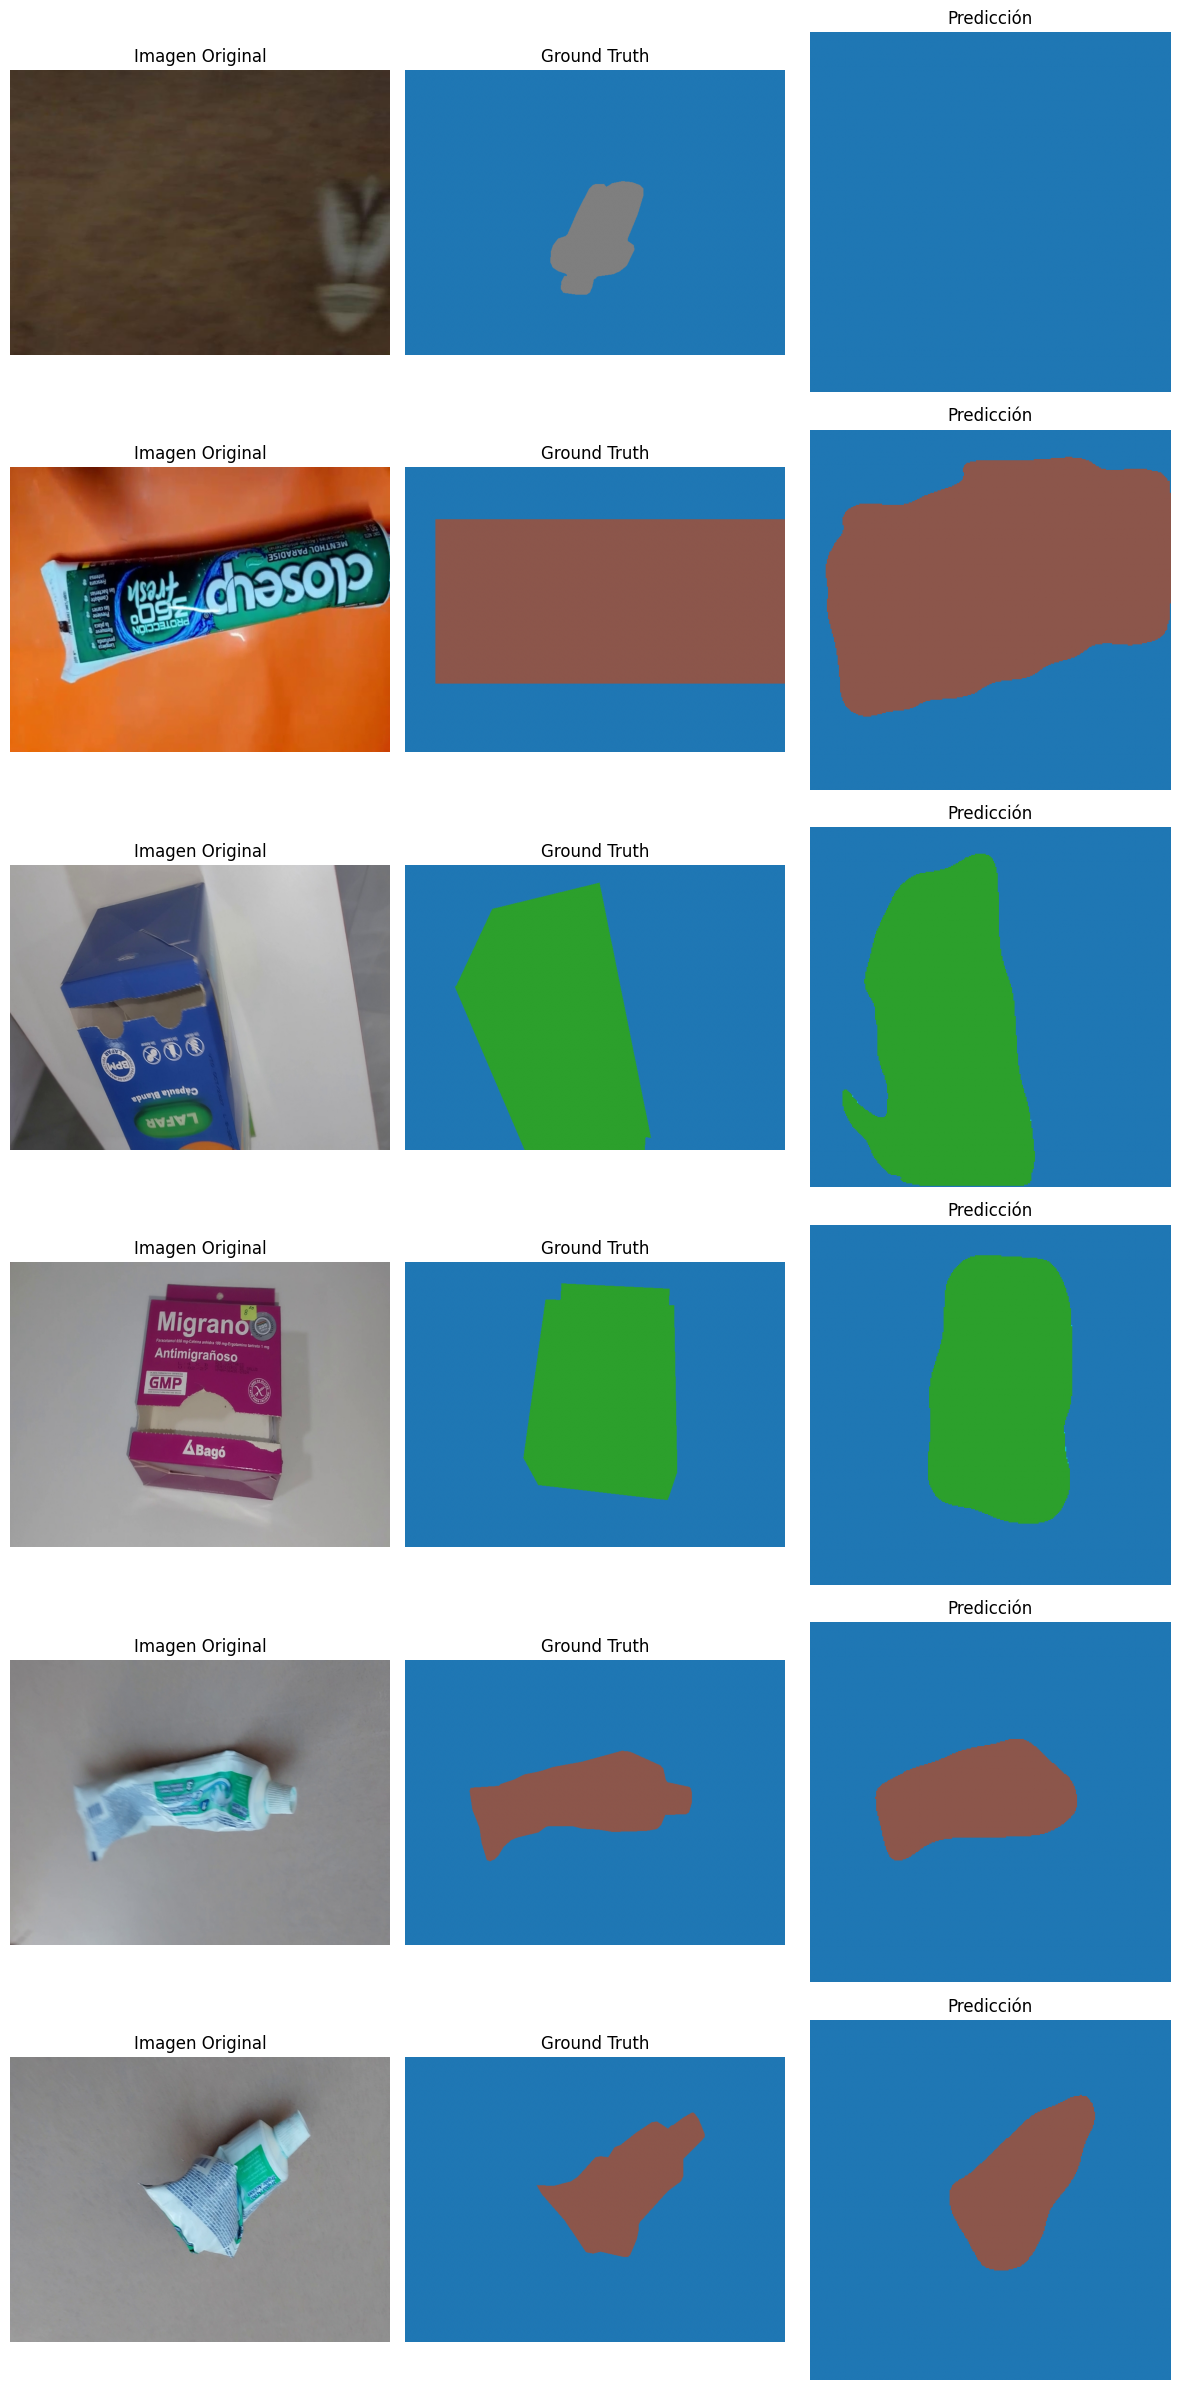

In [ ]:
def visualizar_segmentaciones(modelo, num_ejemplos=6):
    """
    Visualiza las predicciones de segmentación.
    """
    modelo.eval()

    #obtener imágenes de validación
    imagenes_val = os.listdir(VAL_IMG_SEG)
    seleccion = random.sample(imagenes_val, min(num_ejemplos, len(imagenes_val)))

    fig, axes = plt.subplots(num_ejemplos, 3, figsize=(12, 4*num_ejemplos))
    if num_ejemplos == 1:
        axes = axes.reshape(1, -1)

    #paleta de colores para visualización
    colores = plt.cm.get_cmap('tab10', NUM_CLASES_SEG)

    with torch.no_grad():
        for idx, nombre_img in enumerate(seleccion):
            # Cargar imagen original
            img_path = os.path.join(VAL_IMG_SEG, nombre_img)
            img_orig = Image.open(img_path).convert('RGB')

            # Cargar máscara GT
            nombre_base = os.path.splitext(nombre_img)[0]
            mask_path = os.path.join(VAL_MASK_SEG, nombre_base + '.png')
            mask_gt = np.array(Image.open(mask_path))

            # Preparar para el modelo
            img_tensor = transform_seg_eval(img_orig).unsqueeze(0).to(device)

            # Inferencia
            logits = modelo(img_tensor)
            pred = logits.argmax(dim=1).squeeze(0).cpu().numpy()

            # Mostrar imagen original
            axes[idx, 0].imshow(img_orig)
            axes[idx, 0].set_title("Imagen Original")
            axes[idx, 0].axis('off')

            # Mostrar Ground Truth
            axes[idx, 1].imshow(mask_gt, cmap=colores, vmin=0, vmax=NUM_CLASES_SEG-1)
            axes[idx, 1].set_title("Ground Truth")
            axes[idx, 1].axis('off')

            # Mostrar Predicción
            axes[idx, 2].imshow(pred, cmap=colores, vmin=0, vmax=NUM_CLASES_SEG-1)
            axes[idx, 2].set_title("Predicción")
            axes[idx, 2].axis('off')

    plt.tight_layout()
    plt.savefig(f"{RUTA_CHECKPOINTS_SEG}/visualizacion_segmentacion.png", dpi=150)
    plt.show()

# Ejecutar visualización
visualizar_segmentaciones(modelo_seg, num_ejemplos=6)

---
Matriz de confusion
-

Calculando matriz de confusión en validación...


Calculando matriz: 100%|██████████| 28/28 [01:49<00:00,  3.92s/it]


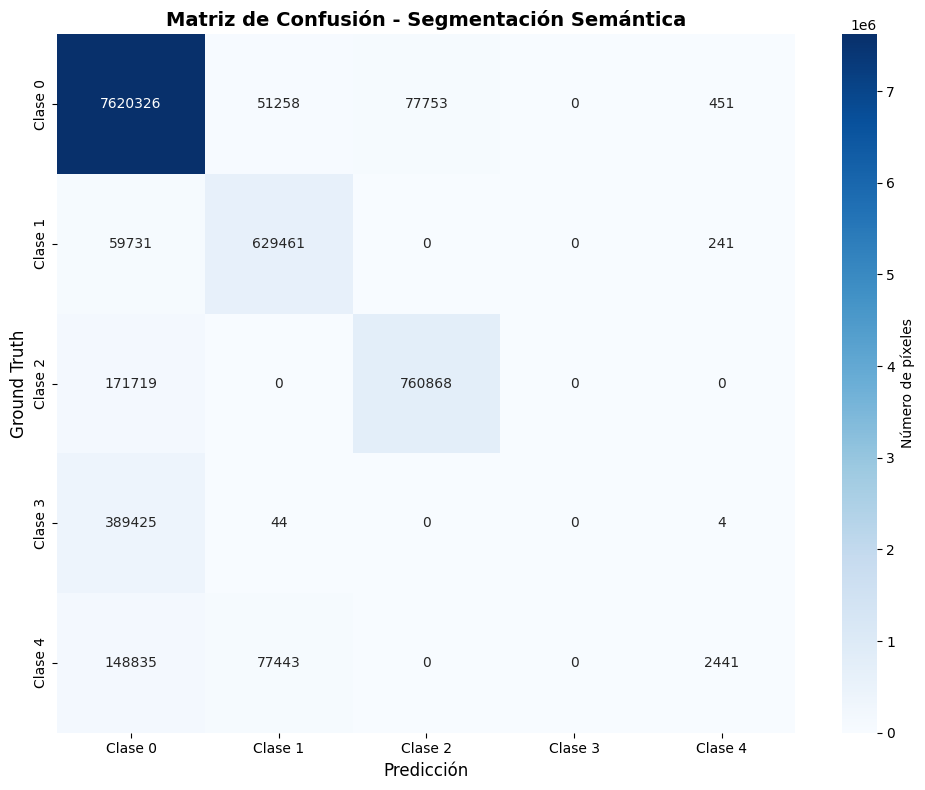

✓ Matriz de confusión guardada


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def calcular_matriz_confusion(modelo, loader):

    modelo.eval()

    todas_preds = []
    todas_targets = []

    with torch.no_grad():
        for imagenes, mascaras in tqdm(loader, desc="Calculando matriz"):
            imagenes = imagenes.to(device)
            mascaras = mascaras.cpu().numpy()

            logits = modelo(imagenes)
            preds = logits.argmax(dim=1).cpu().numpy()

            todas_preds.extend(preds.flatten())
            todas_targets.extend(mascaras.flatten())

    # Calcular matriz de confusión
    cm = confusion_matrix(todas_targets, todas_preds, labels=range(NUM_CLASES_SEG))

    return cm


def visualizar_matriz_confusion(cm):

    plt.figure(figsize=(10, 8))

    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=[f'Clase {i}' for i in range(NUM_CLASES_SEG)],
        yticklabels=[f'Clase {i}' for i in range(NUM_CLASES_SEG)],
        cbar_kws={'label': 'Número de píxeles'}
    )

    plt.xlabel('Predicción', fontsize=12)
    plt.ylabel('Ground Truth', fontsize=12)
    plt.title('Matriz de Confusión - Segmentación Semántica', fontsize=14, weight='bold')

    plt.tight_layout()
    plt.savefig(f"{RUTA_CHECKPOINTS_SEG}/matriz_confusion.png", dpi=150)
    plt.show()

    print(f"✓ Matriz de confusión guardada")

# Calcular y visualizar
print("Calculando matriz de confusión en validación...")
cm = calcular_matriz_confusion(modelo_seg, val_loader_seg)
visualizar_matriz_confusion(cm)

---
Inferencia
-

In [ ]:
def inferir_segmentacion(modelo, ruta_imagen, visualizar=True):

    modelo.eval()

    # Cargar imagen
    img = Image.open(ruta_imagen).convert('RGB')
    img_tensor = transform_seg_eval(img).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = modelo(img_tensor)  # (1, num_clases, H, W)
        pred = logits.argmax(dim=1).squeeze(0).cpu().numpy()
        probs = torch.softmax(logits, dim=1).squeeze(0).cpu().numpy()

    if visualizar:
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        axes[0].imshow(img)
        axes[0].set_title("Imagen Original")
        axes[0].axis('off')

        colores = plt.cm.get_cmap('tab10', NUM_CLASES_SEG)
        axes[1].imshow(pred, cmap=colores, vmin=0, vmax=NUM_CLASES_SEG-1)
        axes[1].set_title("Segmentación")
        axes[1].axis('off')

        plt.tight_layout()
        plt.show()

    return img, pred, probs

print("Función de inferencia lista")

Función de inferencia lista


---
Evaluacion
-

In [ ]:
def evaluar_test_set(modelo):

    modelo.eval()

    test_loader = crear_loader_segmentacion(
        TEST_IMG_SEG,
        TEST_MASK_SEG,
        batch_size=BATCH_SIZE_SEG,
        shuffle=False,
        transform=transform_seg_eval
    )

    test_loss = 0.0
    test_correct = 0
    test_total = 0
    ious_acumulados = [[] for _ in range(NUM_CLASES_SEG)]

    with torch.no_grad():
        for imagenes, mascaras in tqdm(test_loader, desc="Evaluando test"):
            imagenes = imagenes.to(device)
            mascaras = mascaras.to(device)

            logits = modelo(imagenes)
            loss = criterio_seg(logits, mascaras)

            test_loss += loss.item()

            pred = logits.argmax(dim=1)
            test_correct += (pred == mascaras).sum().item()
            test_total += mascaras.numel()

            # IoU por clase
            ious, _ = calcular_iou_por_clase(pred, mascaras, NUM_CLASES_SEG)
            for c in range(NUM_CLASES_SEG):
                if not math.isnan(ious[c]):
                    ious_acumulados[c].append(ious[c])

    # Resultados
    avg_test_loss = test_loss / len(test_loader)
    test_pixel_acc = test_correct / test_total

    ious_medios = []
    for c in range(NUM_CLASES_SEG):
        if ious_acumulados[c]:
            iou_medio = sum(ious_acumulados[c]) / len(ious_acumulados[c])
            ious_medios.append(iou_medio)

    test_miou = sum(ious_medios) / len(ious_medios) if ious_medios else 0.0

    # Mostrar resultados
    print(f"EVALUACIÓN EN TEST SET")
    print(f"Test Loss:        {avg_test_loss:.4f}")
    print(f"Test Pixel Acc:   {test_pixel_acc:.4f}")
    print(f"Test mIoU:        {test_miou:.4f}")
    print(f"\nIoU por clase:")
    for c in range(NUM_CLASES_SEG):
        if ious_acumulados[c]:
            iou_medio = sum(ious_acumulados[c]) / len(ious_acumulados[c])
            print(f"  Clase {c}: {iou_medio:.4f}")
        else:
            print(f"  Clase {c}: N/A")

    return {
        'test_loss': avg_test_loss,
        'test_pixel_acc': test_pixel_acc,
        'test_miou': test_miou
    }

# Evaluar en test
resultados_test = evaluar_test_set(modelo_seg)

Evaluando test: 100%|██████████| 14/14 [00:53<00:00,  3.83s/it]

EVALUACIÓN EN TEST SET
Test Loss:        0.6130
Test Pixel Acc:   0.9024
Test mIoU:        0.4041

IoU por clase:
  Clase 0: 0.8922
  Clase 1: 0.5553
  Clase 2: 0.5711
  Clase 3: 0.0000
  Clase 4: 0.0018


---
Guardar modelo
-

In [ ]:
torch.save(
    modelo_seg.state_dict(),
    f"{RUTA_CHECKPOINTS_SEG}/modelo_segmentacion_final.pth"
)

config_final = {
    'num_clases': NUM_CLASES_SEG,
    'img_size': 300,
    'patch_size': 15,
    'embed_dim': 768,
    'depth': 6,
    'num_heads': 12,
    'resultados_test': resultados_test,
    'historial': historial_seg
}

import pickle
with open(f"{RUTA_CHECKPOINTS_SEG}/config_final.pkl", 'wb') as f:
    pickle.dump(config_final, f)

print("\nMODELO DE SEGMENTACIÓN COMPLETADO Y GUARDADO")
print(f"Modelo guardado en: {RUTA_CHECKPOINTS_SEG}/modelo_segmentacion_final.pth")
print(f"Configuración guardada en: {RUTA_CHECKPOINTS_SEG}/config_final.pkl")



MODELO DE SEGMENTACIÓN COMPLETADO Y GUARDADO
Modelo guardado en: /content/drive/MyDrive/IA2/final/checkpoints_segmentacion/modelo_segmentacion_final.pth
Configuración guardada en: /content/drive/MyDrive/IA2/final/checkpoints_segmentacion/config_final.pkl
